<a href="https://colab.research.google.com/github/mvince33/food-sales-predictions/blob/main/food_sales_prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1
- Michael Vincent
- 7/27

## Imports

In [24]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import set_config
set_config(display = 'diagram')

## Load the data

In [25]:
# Load the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRNQ2yuuZKv8cbgh4i4BHnxryjbO8BUviZeIPvva0lIUS23NLolb67KroUgKUOLljhQwxTJZSZrhnyY/pub?output=csv'
df = pd.read_csv(url)

# Check to make sure the data loaded propeprly
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Explore the data

In [26]:
# Check for duplicates
print('There are', df.duplicated().sum(), 'duplicates in the data set.')

# Check for missing values
print('There are', df.isna().sum().sum(), 'missing values.')

# Find where the missing values are
df.isna().sum()

There are 0 duplicates in the data set.
There are 3873 missing values.


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

> The columns 'Item_Weight' and 'Outlet_Size' have missing values. These will be imputed before we do any data analysis or machine learning.

In [27]:
# Check for inconsistent labelling
for col in df.columns:
  print(col + ':')
  if df[col].dtype == 'object':
    print(df[col].value_counts())
    print()

Item_Identifier:
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

Item_Weight:
Item_Fat_Content:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Visibility:
Item_Type:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Item_MRP:
Outlet_Identifier:
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929

> The 'Item_Fat_Content' has inconsistent labels. We will fix those than make a copy of the DataFrame for machine learning.

In [28]:
# Correct the inconsistent labels in 'Item_Fat_Content'.
df['Item_Fat_Content'].replace(['Low Fat', 'LF', 'low fat', 'reg'],
                               ['Low_Fat', 'Low_Fat', 'Low_Fat', 'Regular'],
                               inplace = True)

# Confirm the changes were made
df['Item_Fat_Content'].value_counts()

Low_Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [29]:
# Make a copy of the DataFrame for machine learning.
ml_df = df.copy()

In [30]:
# Determine the types of data in the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


>Numerical Features:
- Item_Weight
- Item_Visibility
- Item_MRP
- Outlet_Establishment_Year
- Item_Outlet_Sales

>Categorical Features:
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [31]:
# Get the summary statistics
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


> With the exception of the maximum in Item_Outlet_sales all the quartiles are within three standard deviations of the mean.

## Data Analysis

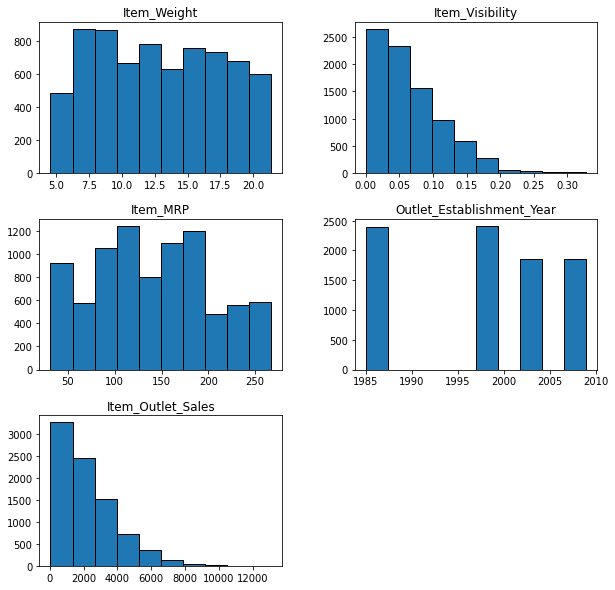

In [32]:
# Make histograms of the numerical data
df.hist(figsize = (10, 10), edgecolor = 'black', grid = False);

> The 'Item_Weight' seems to be fairly uniform. This will not be preserved if we impute with a single value.



In [33]:
# Show the counts of 'Item_Weights' that are missing values.
filter = df['Item_Weight'].isna()
df.loc[filter, 'Item_Type'].value_counts()

Fruits and Vegetables    213
Snack Foods              212
Household                151
Frozen Foods             138
Dairy                    116
Baking Goods             112
Canned                   110
Health and Hygiene        90
Meat                      88
Soft Drinks               71
Breads                    47
Others                    32
Hard Drinks               31
Breakfast                 21
Starchy Foods             18
Seafood                   13
Name: Item_Type, dtype: int64

In [34]:
# Average each category of 'Item_Weights.'
for item_type in df.loc[filter, 'Item_Type'].value_counts().index:
  item_filter = df['Item_Type'] == item_type
  avg = df.loc[item_filter, 'Item_Weight'].mean()
  print('The average weight of the category', item_type,
        'is:', round(avg, 1))

print()

df.isna().sum()
# Find the mean of each category of 'Item_Weights.'
for item_type in df.loc[filter, 'Item_Type'].value_counts().index:
  item_filter = df['Item_Type'] == item_type
  med = df.loc[item_filter, 'Item_Weight'].median()
  print('The median weight of the category', item_type,
        'is:', round(med, 1))

The average weight of the category Fruits and Vegetables is: 13.2
The average weight of the category Snack Foods is: 13.0
The average weight of the category Household is: 13.4
The average weight of the category Frozen Foods is: 12.9
The average weight of the category Dairy is: 13.4
The average weight of the category Baking Goods is: 12.3
The average weight of the category Canned is: 12.3
The average weight of the category Health and Hygiene is: 13.1
The average weight of the category Meat is: 12.8
The average weight of the category Soft Drinks is: 11.8
The average weight of the category Breads is: 11.3
The average weight of the category Others is: 13.9
The average weight of the category Hard Drinks is: 11.4
The average weight of the category Breakfast is: 12.8
The average weight of the category Starchy Foods is: 13.7
The average weight of the category Seafood is: 12.6

The median weight of the category Fruits and Vegetables is: 13.1
The median weight of the category Snack Foods is: 13.

> The above shows that it is reasonable to impute the missing values in 'Item_Weights' with either the mean or the median. We will choose to use the mean. We will impute the missing values in 'Outlet_Size' with the value 'Missing'.

In [35]:
# Impute the missing values
avg = df['Item_Weight'].mean()
df['Item_Weight'].fillna(avg, inplace = True)
df['Outlet_Size'].fillna('Missing', inplace = True)

# Check to make sure missing values were filled
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB



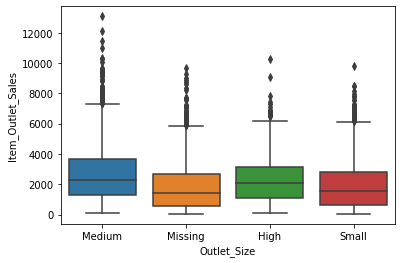

In [36]:
# Construct boxplots for the variables involving the Outlets
df.info()
print()

# Make boxplots for 'Item Outlet Sales' vs. 'Outlet Size'
sns.boxplot(x = 'Outlet_Size', y = 'Item_Outlet_Sales', data = df);

> With the exeception of flagged outliers, the sales are relatively the same by outlet size. Interestingly enough, the outlet size of medium is the highest performing. (But not by much.)

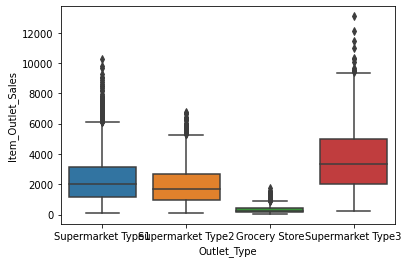

In [37]:
# Make boxplots for 'Item Outlet Sales' vs. 'Outlet_Type'.
sns.boxplot(x = 'Outlet_Type', y = 'Item_Outlet_Sales', data = df);

> These boxplots suggest that grocery stores generate significantly less sales than the supepmarkets.

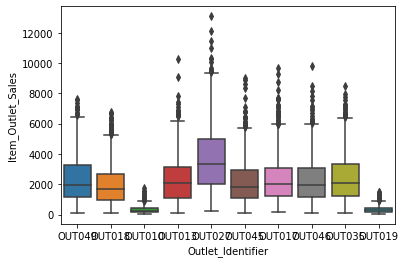

In [38]:
# Make boxplots for 'Item Outlet Sales' vs. 'Outlet Identifier'.
sns.boxplot(x = 'Outlet_Identifier', y = 'Item_Outlet_Sales', data = df);

> These boxplots give sales by outlet identifier.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


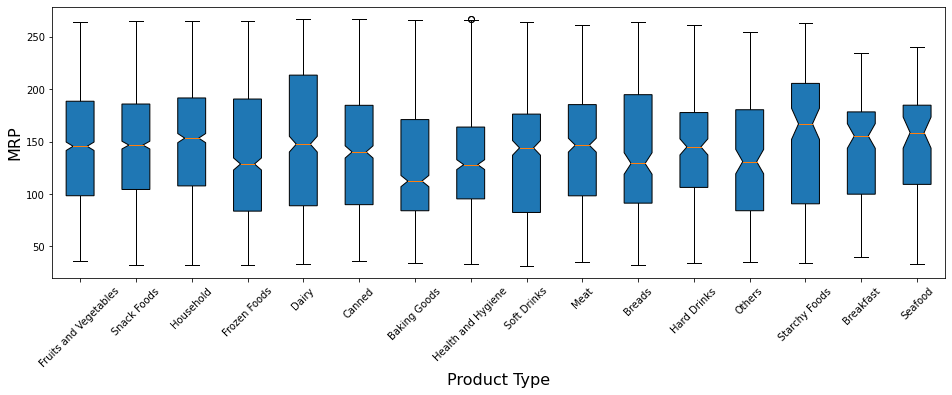

In [39]:
# Boxplots for MRP by item type.

# Get the values to construct boxplots of
food_types = df['Item_Type'].value_counts().index
mrp = [df.loc[df['Item_Type'] == item_type, 'Item_MRP'] for item_type in food_types]

# Construct the boxplots
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 5));
boxplots = axes.boxplot(mrp,
                        labels = food_types,
                        patch_artist = True,
                        notch = True);
plt.xticks(rotation = 45);
plt.xlabel('Product Type', fontsize = 16);
plt.ylabel('MRP', fontsize = 16);

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


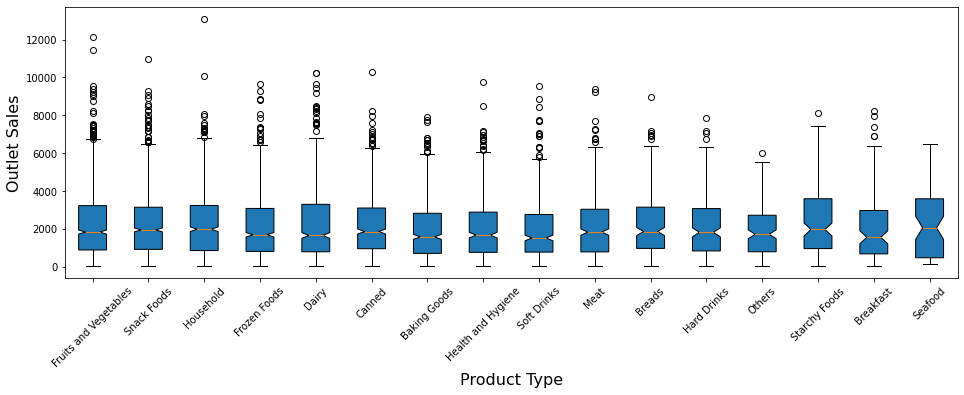

In [40]:
# Construct boxplots for 'Item Type' with the y-axis as 'Item Outlet Sales'.

outlet_sales_by_type = [df.loc[df['Item_Type'] == item_type, 'Item_Outlet_Sales'] for item_type in food_types]
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 5));
boxplots = axes.boxplot(outlet_sales_by_type,
                        labels = food_types,
                        patch_artist = True,
                        notch = True);
plt.xticks(rotation = 45);
plt.xlabel('Product Type', fontsize = 16);
plt.ylabel('Outlet Sales', fontsize = 16);

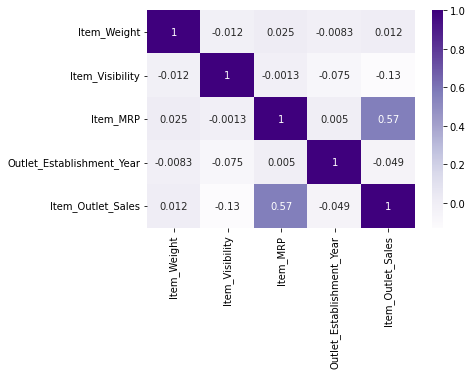

In [41]:
# Construct the heatmap
corr = df.corr()
sns.heatmap(corr, cmap = 'Purples', annot = True);

## Data Interpretation

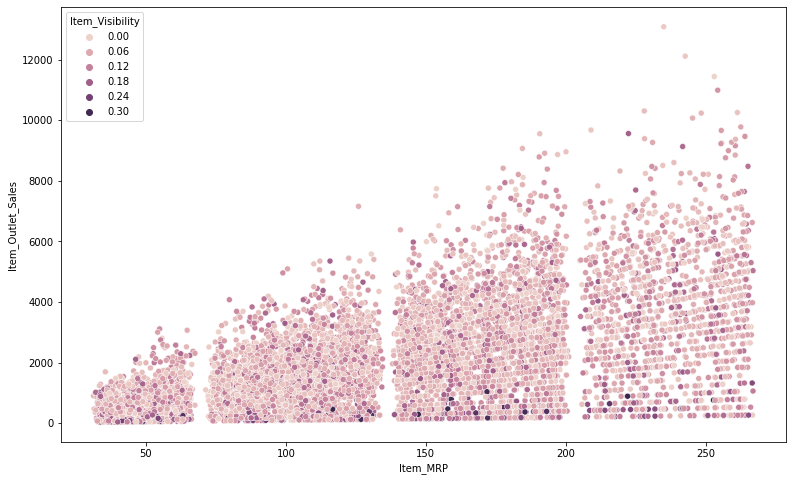

In [42]:
# Create a scatter plot of 'Item_Outlet_Sales' vs. 'Item_MRP'.

plt.figure(figsize = (13, 8));
sns.scatterplot(x = df['Item_MRP'], y = df['Item_Outlet_Sales'], hue = df['Item_Visibility']);

The above scatterplot shows us there is a positive correlation between 'Item_MRP' (manufacturer's retail price?) and sales, where a higher MRP correlates with higher sales. Some caution should be used here as high MRP does not guarantee high sales. The converse is true though. Higher sales correspond with higher MRPs. 

We also used hue to represent the item's visibility. Darker hues correspond with higher visibility, and lighter hues correspond with lower visibility. As we can see on the graph, higher visibility does not correlate with higher sales. Indeed, the highest sales correspond with lower visibilities.

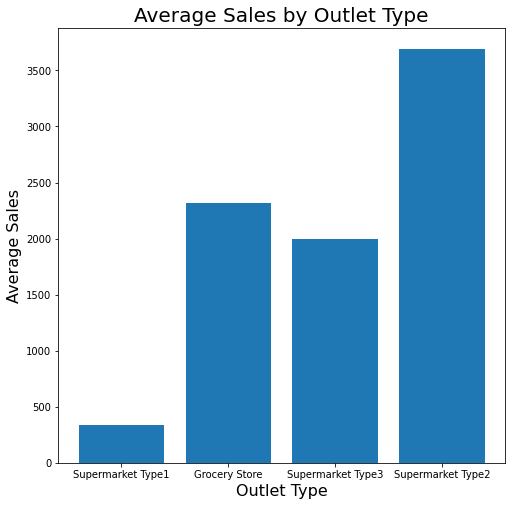

In [43]:
# Construct a bar graph for average sales by outlet type.

# Get the counts of each outlet type
outlet_counts = df['Outlet_Type'].value_counts()
# Get the average sales of each outlet type
cum_sales_by_outlet = df.groupby('Outlet_Type')['Item_Outlet_Sales'].sum() / outlet_counts

# Plot average sales by outlet type
plt.figure(figsize = (8, 8));
plt.bar(df['Outlet_Type'].value_counts().index, cum_sales_by_outlet);
plt.xlabel('Outlet Type', fontsize = 16);
plt.ylabel('Average Sales', fontsize = 16);
plt.title('Average Sales by Outlet Type', fontsize = 20);

>This graph reveals that the average sales _by outlet type_ reveal that grocery stores are not underperforming, it is actually supermarket type 1 that is underperforming.

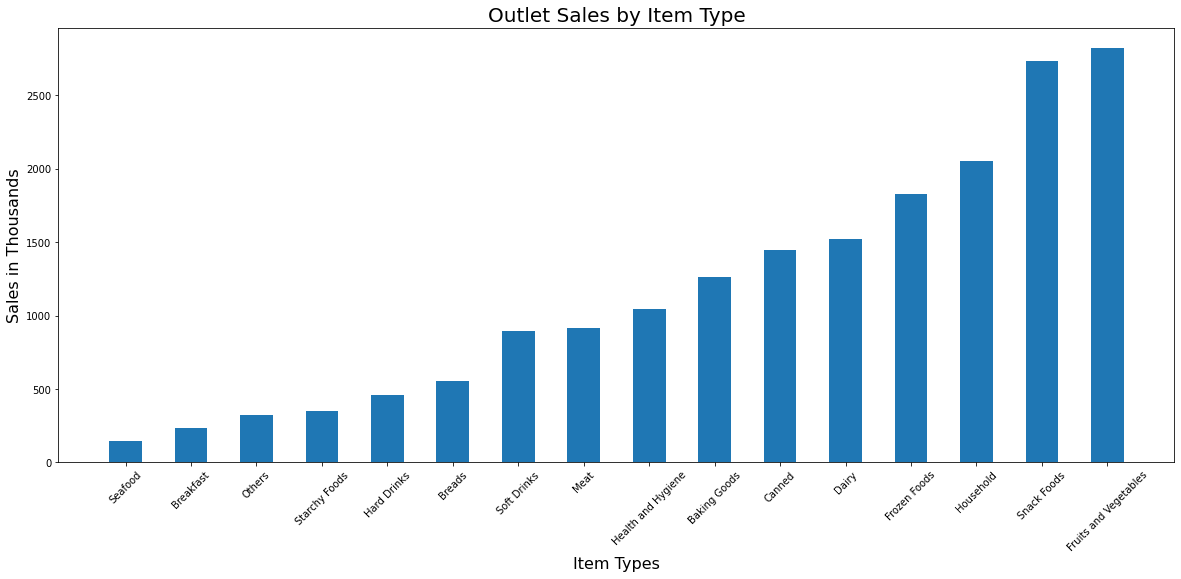

In [44]:
# Make a bar chart for cumulative sales by item type
cum_sales_by_type = df.groupby('Item_Type')['Item_Outlet_Sales'].sum() / 1000
cum_sales_by_type.sort_values(inplace = True)

# Construct the graph
plt.figure(figsize = (20, 8));
plt.bar(cum_sales_by_type.index, cum_sales_by_type, width = 0.5);
plt.xticks(rotation = 45);
plt.xlabel('Item Types', fontsize = 16);
plt.ylabel('Sales in Thousands', fontsize = 16);
plt.title('Outlet Sales by Item Type', fontsize = 20);

>

> This graph orders the sales of each item type from lowest sales to highest sales.